<a href="https://colab.research.google.com/github/chebbal/data-centric-deep-learning/blob/main/week1/Copy_of_Data_Quality_Effect_on_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Quality: Effect of Data Quality on Performance

> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

What exactly is the impact of data error and annotation error on performance? To answer this, we will return to our trusty Stanford Sentiment Treebank (SST) dataset (we saw this before in the Deep Learning Refresher), and measure it ourselves! 

Now we put on our hat as an evil adversary whose job is to reduce data quality. What happens when we corrupt the inputs more and more? What happens when we corrupt the annotations? What is the magnitude of impact on test accuracy?

One of the sub-goals of the course is to see the same concepts across different data modalities to provide student's a broader learning landscape. Towards this goal, we will also run an analogous experiment in an image context using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, a popular benchmark dataset for image classification. 

### Setup

You will need your a GPU for this notebook. Click Runtime in the Colab menu and change your runtype. 

### Install Dependencies

In [1]:
!pip install numpy
!pip install matplotlib
!pip install jsonlines
!pip install tqdm
!pip install datasets
!pip install pytorch-lightning
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 54.2 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 212 kB 74.0 MB/s 
     |████████████████████████████████| 86 kB 7.5 MB/s 
     |████████████████████████████████| 140 kB 79.1 MB/s 
     |████████████████████████████████| 596 kB 60.1 MB/s 
     |████████████████████████████████| 127 kB 77.8 MB/s 
     |████████████████████████████████| 94 kB 

# Let's get started!

To begin, we will load our libraries, and download the SST data and pre-computed features. If you haven't seen the [Deep Learning Refresher](https://colab.research.google.com/drive/1RzpqXcNnCqdczkEG8El51chYsu8umscw), it would be worth reviewing as some of the code here is based on that notebook.

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from datasets import load_dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

def seed_everything(seed, use_cuda=True):
  # so results are reproducible!
  random.seed(seed)
  torch.manual_seed(seed)
  if use_cuda: 
    torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)

Let's download our BERT feature bank on SST from the Deep Learning Refresher. As a reminder, we pre-computed BERT features (size 768 vectors) for every example in the SST dataset. There are three files below for the training, dev, and test splits. 

If you haven't seen BERT before, it is a large neural network for natural language that maps arbitrary text to feature vectors. We recommend this [blog](https://jalammar.github.io/illustrated-bert/), which has a fantastic explanation. In practice, it is common to build on top of pretrained feature vectors rather than starting from the raw text. In this notebook, we will be training a small network on top of the BERT features.

In [3]:
!gdown --id 17fCCxc0XrfCxLs9uUp9v1OY7v1Sc9pPP
!gdown --id 18_KoA8kLhg_GIxzyjLqMID1I51397F1X
!gdown --id 1koPWrlRKXV_nQmyGVHE7Z4X0VLrAjn-_

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17fCCxc0XrfCxLs9uUp9v1OY7v1Sc9pPP
To: /content/sst-roberta-train.pt
100% 26.2M/26.2M [00:00<00:00, 227MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18_KoA8kLhg_GIxzyjLqMID1I51397F1X
To: /content/sst-roberta-dev.pt
100% 3.38M/3.38M [00:00<00:00, 273MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloadin

In [4]:
train_features = torch.load('sst-roberta-train.pt')
dev_features = torch.load('sst-roberta-dev.pt')
test_features = torch.load('sst-roberta-test.pt')

# check the shape
print(train_features.size())

torch.Size([8544, 768])


Create a PyTorch Dataset that loads the SST data but takes two additional parameters: `data_noise` and `label_noise`.

Both will be a number between 0 and 1. The parameter `data_noise` represents the probability of adding Gaussian noise to the data. The parameter `label_noise` represents the probability of flipping the label (e.g. map 0 to 1 and map 1 to 0).

In [20]:
def flip(weight):
  # You may find this function helpful below!
  return np.random.rand() < weight

class CorruptSSTBERT(Dataset):
  """
  Your task is to fill in some of the class methods. 
  """

  def __init__(self, data_noise = 0, label_noise = 0, split = 'train'):
    super().__init__()
    assert split in ['train', 'dev', 'test'], f"Split {split} not supported."
    self.features = torch.load(f'sst-roberta-{split}.pt').cpu()
    if split == 'dev': split = 'validation'
    self.split = split
    self.data = load_dataset('sst', split = split)

    self.data_noise = data_noise
    self.label_noise = label_noise

  def __getitem__(self, index):
    feature = self.features[index]
    # ================================
    # FILL ME OUT
    # 
    # With some probability, add noise from a Gaussian
    # distribution with mean 0 and stdev 1.
    # 
    # HINT: the `flip` function may be helpful. To draw random
    # samples, use `torch.rand_like(...)`. 
    # 
    # Solution code is two lines.
    # 
    # Pseudocode:
    # --
    # if flip is successful:
    #   add noise to feature
    # 
    # Type:
    # --
    # feature: torch.FloatTensor
    # ================================
    #weight = torch.rand_like()
    if flip(self.data_noise):
      feature = feature + torch.normal(torch.tensor([0.0]), torch.tensor([1.0]))


    label = round(self.data[index]['label'])
    # ================================
    # FILL ME OUT
    #
    # With some probability, flip the label.
    #
    # Solution code is two lines.
    # 
    # Pseudocode:
    # --
    # if flip is successful:
    #   change label
    # 
    # Type:
    # --
    # label: integer (0 or 1)
    # ================================
    if flip(self.label_noise):
      label = 1 if label == 0 else 0
    return feature, label

  def __len__(self):
    return self.data.num_rows

Next we create a `DataModule`. A DataModule is a PyTorch Lightning data structure that makes it easy 
for PyTorch Lightning's Trainer (which we use below) to interact with DataLoaders.

In [7]:
class SSTDataModule(pl.LightningDataModule):
  """
  This is largely a wrapper around three datasets and their respective data
  loaders. This also sets the batch_size (default is 32).
  """

  def __init__(self, data_noise = 0, label_noise = 0, batch_size: int = 32):
    super().__init__()
    # Call CorruptSSTBERT rather than SSTBERT
    self.sst_train = CorruptSSTBERT(data_noise, label_noise, split = 'train')
    self.sst_dev = CorruptSSTBERT(data_noise, label_noise, split = 'dev')
    self.sst_test = CorruptSSTBERT(data_noise, label_noise, split = 'test')
    self.batch_size = batch_size

  def train_dataloader(self):
    return DataLoader(self.sst_train, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.sst_dev, batch_size=self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.sst_test, batch_size=self.batch_size)

  def predict_dataloader(self):
    return DataLoader(self.sst_test, batch_size=self.batch_size)

Define the neural network to predict sentiment. This network will take as input features from BERT. 

In [8]:
class MLP(nn.Module):
  """
  Feel free to customize me if you want to see the effects of 
  data quality using different neural networks. For the first 
  run, keep this simple (one linear layer aka logistic 
  regression) so that it is fast to run.
  """

  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, 1)  # logistic regression
    
  def forward(self, x):
    return torch.sigmoid(self.fc1(x))

Finally, we define the PyTorch Lightning System. If you haven't used Lightning before, this is the meat of it. The system instantiates the model and optimizer and also requires the user to define functionalities for a training step and an evaluation step. The benefit of this standardization is less room for bugs. 

In [9]:
class SSTSystem(pl.LightningModule):
  """
  Defines a binary cross entropy loss between predicted
  probabilites of positive sentiment and the true label. 
  """

  def __init__(self):
    super().__init__()
    self.model = MLP(768, 1) 

  def forward(self, features):
    probs = self.model(features)
    return probs

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

  def _common_step(self, batch, batch_idx):
    features, labels = batch
    labels = labels.unsqueeze(1).float()

    probs = self.forward(features)
    loss = F.binary_cross_entropy(probs, labels)

    with torch.no_grad():
      preds = torch.round(probs.squeeze(1))
      num_correct = torch.sum(preds == labels.squeeze(1)).item() 
      num_total = labels.size(0)
      accuracy = num_correct / float(num_total)

    return loss, accuracy

  def training_step(self, train_batch, batch_idx):
    loss, acc = self._common_step(train_batch, batch_idx)
    self.log('train_loss', loss)
    self.log('train_acc', acc, prog_bar=True)
    return loss

  def validation_step(self, dev_batch, batch_idx):
    loss, acc = self._common_step(dev_batch, batch_idx)
    self.log('dev_loss', loss)
    self.log('dev_acc', acc, prog_bar=True)

  def test_step(self, test_batch, batch_idx):
    loss, acc = self._common_step(test_batch, batch_idx)
    self.log('test_loss', loss)
    self.log('test_acc', acc)

  def predict_step(self, batch, batch_idx):
    return self.forward(batch[0])

The last thing to do before running experiments is to put the data module and the lightning system together. 

In [10]:
# finally, add a training function

def train_test_pipeline(data_noise = 0, label_noise = 0):
  seed_everything(42, use_cuda = True)
  # pass this callback to the trainer - it saves the best model
  # based on the dev loss. 
  checkpoint_callback = ModelCheckpoint(monitor = 'dev_loss')

  # Initialize the data module, the lightning system and use 
  # Trainer to fit a model and evaluate performance using the 
  # best checkpoint found in training. This function should 
  # return the accuracy on the test set.
  # 
  # Learn more about the Trainer class here:
  # https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html
  # 
  dm = SSTDataModule(
    data_noise = data_noise, 
    label_noise = label_noise, 
    batch_size = 32)
  model = SSTSystem()
  trainer = Trainer(max_epochs = 20, gpus = 1, 
    callbacks = [checkpoint_callback])
  trainer.fit(model, dm)
  results = trainer.test(model, dm, ckpt_path = "best")

  return results[0]['test_acc']

Let's first study label noise. As we increase it from 0% to 100%, how does this effect test performance?

In [12]:
# A single model takes 2-3 minutes to train, so this job may take a few minutes.
label_noise_results = []
label_noise_choices = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for label_noise in label_noise_choices:
  test_acc = train_test_pipeline(label_noise = label_noise)
  label_noise_results.append(test_acc)

No config specified, defaulting to: sst/default


Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


Dataset sst downloaded and prepared to /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff. Subsequent calls will reuse this data.


No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=19-step=5340.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=19-step=5340.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7425339221954346
        test_loss           0.6284145712852478
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=19-step=5340.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=19-step=5340.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7040724158287048
        test_loss           0.6491921544075012
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_2/checkpoints/epoch=15-step=4272.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_2/checkpoints/epoch=15-step=4272.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.64841628074646
        test_loss           0.6726792454719543
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_3/checkpoints/epoch=15-step=4272.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_3/checkpoints/epoch=15-step=4272.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5914027094841003
        test_loss           0.6834602952003479
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_4/checkpoints/epoch=19-step=5340.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_4/checkpoints/epoch=19-step=5340.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5253393650054932
        test_loss           0.6909616589546204
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_5/checkpoints/epoch=13-step=3738.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_5/checkpoints/epoch=13-step=3738.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5140271782875061
        test_loss            0.694299042224884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


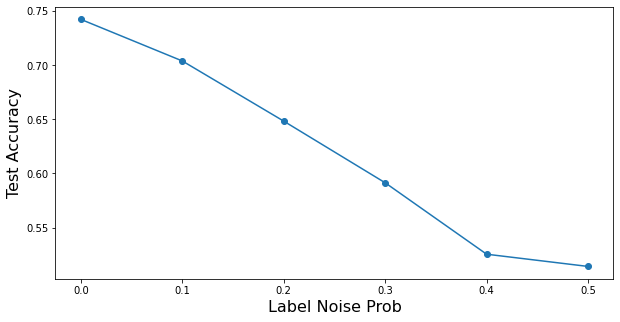

In [13]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(label_noise_choices, label_noise_results, '-o')
plt.xlabel('Label Noise Prob', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=16)
plt.show()

We can see that performance steadily decays as the amount of label noise increases. As expected, when the probability of flipping label is 50%, the performance drops to around 50% accuracy, which is the same as randomly guessing positive or negative sentiment. This makes sense since we are adding enough noise that the resulting label is random!

The other important takeaway is that we can live with a little bit of noise. Even adding 10% of annotation noise only decreases performance by 5%. Real world annotators are not going to perfect and there will always be some annotation error. But a little may not be the end of the world. But too much noise, and performance will suffer greatly. That is why it is so important to ensure and protect data quality.

> **Question**: What do you think would happen if we set `p` to be bigger than 0.5? What do you expect performance to be if `p = 1`?

> **Your Answer**: Around `p = 0.5` we already see degraded model behaviour of randomly guessing labels, anything above `p = 0.5` there will not be much change in model behaviour relative to model at `p = 0.5`

Next, let's study data noise, where we will corrupt the BERT features rather than the annotated labels. How does this impact performance? 

In [21]:
data_noise_results = []
data_noise_choices = [0, 0.01, 0.02, 0.05, 0.1]
for data_noise in data_noise_choices:
  test_acc = train_test_pipeline(data_noise = data_noise)
  data_noise_results.append(test_acc)

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_9/checkpoints/epoch=19-step=5340.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_9/checkpoints/epoch=19-step=5340.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7425339221954346
        test_loss           0.6284145712852478
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_10/checkpoints/epoch=19-step=5340.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_10/checkpoints/epoch=19-step=5340.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7307692170143127
        test_loss           0.6614314913749695
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_11/checkpoints/epoch=18-step=5073.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_11/checkpoints/epoch=18-step=5073.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6791855096817017
        test_loss           0.6715537905693054
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_12/checkpoints/epoch=19-step=5340.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_12/checkpoints/epoch=19-step=5340.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7013574838638306
        test_loss           0.6746966242790222
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | MLP  | 769   
-------------------------------
769       Trainable params
0         Non-trainable params
769       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /content/lightning_logs/version_13/checkpoints/epoch=17-step=4806.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_13/checkpoints/epoch=17-step=4806.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6904977560043335
        test_loss           0.6800246238708496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


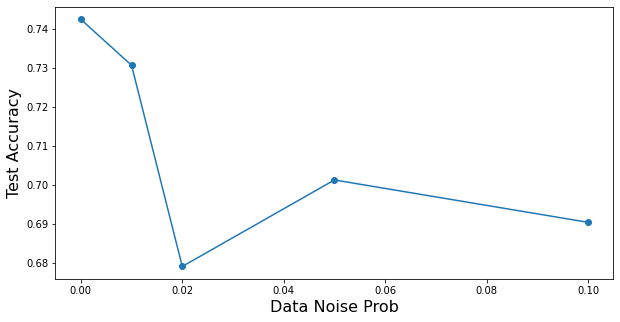

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(data_noise_choices, data_noise_results, '-o')
plt.xlabel('Data Noise Prob', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=16)
plt.show()

We can't directly compare the impact of data noise to label noise but at the very least we can see that a bit of noise added to the features impacts performance a lot. A 2% chance of adding noise drops performance by almost 15%. A big takeaway here is that noise in the data impacts model performance significantly. It is very important to remove noise as best as you can before giving data to a model. Just because you have a lot of data does not guarantee that the model will learn something useful if that data is noisy.

# What about images?

Next, let's study the effects of corruption on an image corpus. Focusing on data noise, there are lot of ways we can manipulate images! We will try corrupting the raw image different transformations like changing the resolution, the saturation, or adding a watermark. 

To get started, let's download the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) and inspect one of the images to get a feel for the data. 

In [1]:
from PIL import Image
from torchvision import datasets, transforms

train_dataset = datasets.CIFAR10(
    './cifar', train=True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(
    './cifar', train=False, download = True, transform = transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Each data point is a 32 by 32 pixel RGB image. Each label will be a number between 0 and 9, meaning there are 10 total classes in the CIFAR10 dataset. The goal of image classification is to predict which object is the image! 

its a frog! (label=6)


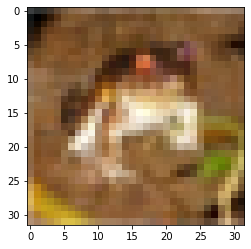

In [4]:
image, label = train_dataset.__getitem__(0)  # get the first example!
pil_image = transforms.ToPILImage()(image)
plt.imshow(pil_image)
print(f'its a frog! (label={label})')

## Image Noise

There is wide variety of image transformations that could be considered noise. Here we will study three different practical examples you might find in the real world: different image resolutions, image filteres, and camera angles. 

### Blurring 
We can simulate images of different resolutions by blurring images. 

original image


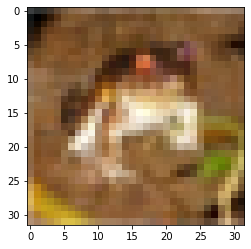

lightly blurred image


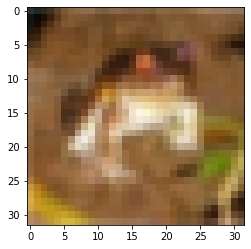

heavily blurred image


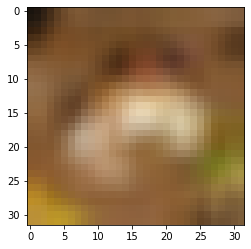

In [5]:
print('original image')
pil_image = transforms.ToPILImage()(image)
plt.imshow(pil_image)
plt.show()

print('lightly blurred image')
blurring = transforms.GaussianBlur(kernel_size=5, sigma=0.5)
blurred_image = blurring(image)
pil_image = transforms.ToPILImage()(blurred_image)
plt.imshow(pil_image)
plt.show()

print('heavily blurred image')
# increasing sigma applies more blurring
blurring = transforms.GaussianBlur(kernel_size=5, sigma=5)
blurred_image = blurring(image)
pil_image = transforms.ToPILImage()(blurred_image)
plt.imshow(pil_image)
plt.show()

### Color transforms
We can simulate image filters by transforming applying jitter to the color spectrums in images. 

original image


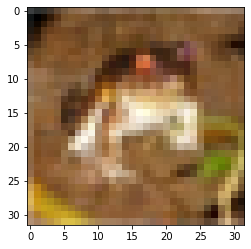

lightly jittered image


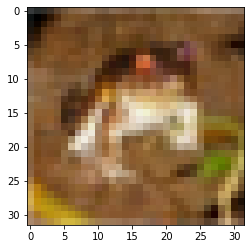

heavily jittered image


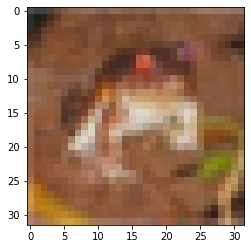

In [6]:
print('original image')
pil_image = transforms.ToPILImage()(image)
plt.imshow(pil_image)
plt.show()

print('lightly jittered image')
jitter = transforms.ColorJitter(
    brightness=.1, hue=.05, contrast=.05, saturation=.05)
jittered_image = jitter(image)
pil_image = transforms.ToPILImage()(jittered_image)
plt.imshow(pil_image)
plt.show()

print('heavily jittered image')
# increasing brightness/hue/contrast/saturation applies more jitter
jitter = transforms.ColorJitter(
    brightness=.1, hue=.5, contrast=.5, saturation=.5)
jittered_image = jitter(image)
pil_image = transforms.ToPILImage()(jittered_image)
plt.imshow(pil_image)
plt.show()

### Rotation
We can simulate different camera angles by randomly rotating images.  


original image


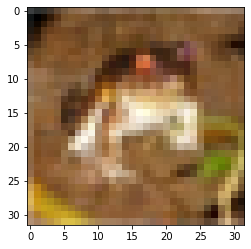

lightly rotated image


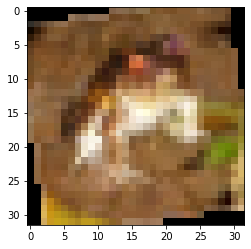

heavily rotated image


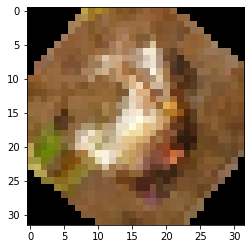

In [7]:
print('original image')
pil_image = transforms.ToPILImage()(image)
plt.imshow(pil_image)
plt.show()

print('lightly rotated image')
rotation = transforms.RandomRotation(degrees=(-10, 10))
rotated_image = rotation(image)
pil_image = transforms.ToPILImage()(rotated_image)
plt.imshow(pil_image)
plt.show()

print('heavily rotated image')
# increasing degrees applies more rotation
rotation = transforms.RandomRotation(degrees=(-180, 180))
rotated_image = rotation(image)
pil_image = transforms.ToPILImage()(rotated_image)
plt.imshow(pil_image)
plt.show()

## Image Modeling

We will be training a small convolutional neural network to classify objects 
from the raw image. Unlike the NLP example, we won't be using pretrained features this time around. 

In [8]:
class CNN(nn.Module):
  """
  A convolutional neural network for images.
  """
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    # The output will be a vector of 10 real numbers representing
    # `logits` for each of the 10 classes. 
    return x

Here is an example of using the CNN (untrained) on a data point.

In [9]:
image, _ = train_dataset.__getitem__(0)
inputs = image.unsqueeze(0)  # shape: 1 x 3 x 32 x 32

with torch.no_grad():
  model = CNN()
  logits = model(inputs)  # shape: 1 x 10
  print(logits.squeeze())

tensor([ 0.0557,  0.0288,  0.1500, -0.0291, -0.0334, -0.0431, -0.0413,  0.0598,
         0.0879, -0.1008])


These predictions represent unnormalized probabilities for each of the 10 classes. To normalize them, we can use the softmax function.

In [10]:
probs = F.softmax(logits, dim=1)
print(probs.squeeze())

tensor([0.1040, 0.1013, 0.1143, 0.0956, 0.0952, 0.0943, 0.0944, 0.1045, 0.1074,
        0.0890])


Currently, the model thinks there is a ~9-10% chance this image is a frog. Since it isn't a trained model, it makes sense that this is near chance probability (10% since there are 10 classes). 

## Setup

Okay! That's enough review of computer vision. We are ready to simulate the effects of these different image corruptions. As we did before, we will setup (1) a `Dataset` class to enable to to toggle the amount of corruption, (2) a DataModule, and (3) a Lightning System. 

We will provide the code for (1) but we will need your help with (2) and (3)! Review the DataModule and PyTorch Lightning system from the NLP example above. We provide scaffold code below that you will need to complete.

In [11]:
class CorruptCIFAR10(Dataset):
  """Dataset for loading corrupted CIFAR10 images. 

  Arguments
  ---------
  noise_type (str, default = blur): the type of data corruption. 
    Choices: blur, jitter, rotate, none

  noise_level (str, default = light): the amount of corruption
    Choices: light, medium, heavy

    Note: unlike the NLP example where we continuously toggle the amount of 
    corruption, here we just chose between a few modes!

  train (bool, default = True): train or test split?
  """
  def __init__(self, noise_type = 'blur', noise_level = 'light', train = True):
    super().__init__()
    assert noise_type in ['none', 'blur', 'jitter', 'rotate']
    assert noise_level in ['light', 'medium', 'heavy']
    
    self.noise_type = noise_type
    self.noise_level = noise_level

    self.dataset = datasets.CIFAR10('./cifar', 
      train = train, download = True, transform = self.get_transforms())

  def get_transforms(self):
    if self.noise_type == 'none':
      # do nothing!
      return transforms.ToTensor()

    elif self.noise_type == 'blur':
      if self.noise_level == 'light':
        max_sigma = .5
      elif self.noise_level == 'medium':
        max_sigma = 2
      elif self.noise_level == 'heavy':
        max_sigma = 5
      return transforms.Compose([
        transforms.GaussianBlur(kernel_size=5, sigma=max_sigma),
        transforms.ToTensor()
      ])

    elif self.noise_type == 'jitter':
      if self.noise_level == 'light':
        max_jitter = .05
      elif self.noise_level == 'medium':
        max_jitter = .2
      elif self.noise_level == 'heavy':
        max_jitter = .5
      return transforms.Compose([
        transforms.ColorJitter(brightness=.1, 
          hue=max_jitter, contrast=max_jitter, saturation=max_jitter),
        transforms.ToTensor()
      ])

    elif self.noise_type == 'rotate':
      if self.noise_level == 'light':
        max_degree = 10
      elif self.noise_level == 'medium':
        max_degree = 45
      elif self.noise_level == 'heavy':
        max_degree = 180
      return transforms.Compose([  # first rotate, then transform
        transforms.RandomRotation(degrees=(-max_degree, max_degree)),
        transforms.ToTensor()
      ])
  def __getitem__(self, index):
    image, label = self.dataset.__getitem__(index)
    return image, label

  def __len__(self):
    return len(self.dataset)

In [12]:
class CIFAR10DataModule(pl.LightningDataModule):
  """Wrapper around the CorruptCIFAR10 class."""

  def __init__(self, 
    noise_type = 'blur', noise_level = 'light', batch_size: int = 32):
    super().__init__()
    self.cifar_train = None
    self.cifar_test = None  # no dev split for CIFAR10
    # ============================
    # FILL ME OUT
    # 
    # Populate `cifar_train` with a corrupted dataset using the `noise_level`
    # and `noise_type` specified above. Populate `cifar_test` with a 
    # *uncorrupted* dataset that we will use to measure performance. 
    # What `noise_level` should be used for an uncorrupted dataset? 
    # 
    # Pseudocode:
    # --
    # self.cifar_train = ...
    # self.cifar_test = ...
    #  
    # Type:
    # --
    # self.cifar_*: CorruptCIFAR10
    # ============================
    self.batch_size = batch_size
    self.cifar_train = CorruptCIFAR10(noise_type, noise_level,train=True)
    self.cifar_test  = CorruptCIFAR10(noise_type, noise_level,train=False)

  def train_dataloader(self):
    return DataLoader(self.cifar_train, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.cifar_test, batch_size=self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.cifar_test, batch_size=self.batch_size)

  def predict_dataloader(self):
    return DataLoader(self.cifar_test, batch_size=self.batch_size)

In [21]:
class CIFAR10System(pl.LightningModule):
  """
  Defines a cross entropy loss between predicted probabilites of the object 
  class and the true label from CIFAR10. 
  """

  def __init__(self):
    super().__init__()
    self.model = None
    # ============================
    # FILL ME OUT
    # 
    # Initialize the convolutional network into the `self.model` variable.
    # 
    # Solution code is one line of code.
    # 
    # Pseudocode:
    # --
    # self.model = ...
    # 
    # Type:
    # --
    # self.model: nn.Module
    # ============================
    self.model = CNN()

  def forward(self, features):
    # remember, these are unnormalized!
    logits = self.model(features)
    return logits

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

  def _common_step(self, batch, batch_idx):
    features, labels = batch
    logits = self.forward(features)

    loss = None
    # ============================
    # FILL ME OUT
    # 
    # Compute the cross entropy loss between logits and labels. Note 
    # that we are not longer in a binary classification task. Make sure
    # to use the right version of cross entropy.
    # 
    # Solution code is one line of code.
    # 
    # Pseudocode:
    # --
    # loss = ...
    # 
    # Type:
    # --
    # loss: torch.FloatTensor
    #   shape: 1
    # ============================
    #print(labels)
    loss = F.binary_cross_entropy_with_logits(logits, F.one_hot(labels, num_classes=10).float())

    with torch.no_grad():
      preds = torch.argmax(logits, dim=1)  # biggest logit = biggest prob
      num_correct = torch.sum(preds == labels).item() 
      num_total = labels.size(0)
      accuracy = num_correct / float(num_total)

    return loss, accuracy

  def training_step(self, train_batch, batch_idx):
    loss, acc = self._common_step(train_batch, batch_idx)
    self.log('train_loss', loss)
    self.log('train_acc', acc, prog_bar=True)
    return loss

  def validation_step(self, dev_batch, batch_idx):
    loss, acc = self._common_step(dev_batch, batch_idx)
    self.log('dev_loss', loss)
    self.log('dev_acc', acc, prog_bar=True)

  def test_step(self, test_batch, batch_idx):
    loss, acc = self._common_step(test_batch, batch_idx)
    self.log('test_loss', loss)
    self.log('test_acc', acc)

  def predict_step(self, batch, batch_idx):
    return self.forward(batch[0])

Let's put it together with a pipeline function to call the system you wrote!

In [14]:
def train_test_pipeline(noise_type = 'blur', noise_level = 'light'):
  seed_everything(42, use_cuda = True)
  dm = CIFAR10DataModule(noise_level = noise_level, noise_type = noise_type,
    batch_size = 64)
  model = CIFAR10System()
  trainer = Trainer(max_epochs = 5, gpus = 1)
  trainer.fit(model, dm)
  results = trainer.test(model, dm)

  return results[0]['test_acc']

## Image Experiments!

Okay, we are all setup to run our experiments. Let's start with blur and vary the noise level from light to heavy to check the performance. 

In [22]:
# Each model takes roughly 1-3 minutes to train. Go take walk or get a coffee! 
# Come back in 10 minutes :) 
no_blur_acc = train_test_pipeline(noise_type = 'none')  # baseline
light_blur_acc = train_test_pipeline(noise_type = 'blur', noise_level = 'light')
medium_blur_acc = train_test_pipeline(noise_type = 'blur', noise_level = 'medium')
heavy_blur_acc = train_test_pipeline(noise_type = 'blur', noise_level = 'heavy')

Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5264999866485596
        test_loss           0.2048431634902954
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.48410001397132874
        test_loss           0.22096887230873108
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.47999998927116394
        test_loss           0.22499509155750275
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4871000051498413
        test_loss           0.2221660166978836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Let's plot the results on a bar plot.

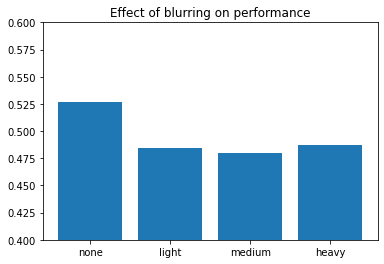

In [23]:
plt.figure()
plt.bar(['none', 'light', 'medium', 'heavy'], 
        [no_blur_acc, light_blur_acc, medium_blur_acc, heavy_blur_acc])
plt.ylim(0.4, 0.6)
plt.title('Effect of blurring on performance')
plt.show()

We can run the other two transformations as well, which will help us compare the effects of different noise types.

In [24]:
# run me for jitter experiments!
no_jitter_acc = train_test_pipeline(noise_type = 'none')  # baseline
light_jitter_acc = train_test_pipeline(noise_type = 'jitter', noise_level = 'light')
medium_jitter_acc = train_test_pipeline(noise_type = 'jitter', noise_level = 'medium')
heavy_jitter_acc = train_test_pipeline(noise_type = 'jitter', noise_level = 'heavy')

Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5242000222206116
        test_loss           0.20533229410648346
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5293999910354614
        test_loss           0.20529469847679138
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4964999854564667
        test_loss           0.21999254822731018
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4927000105381012
        test_loss           0.22350361943244934
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


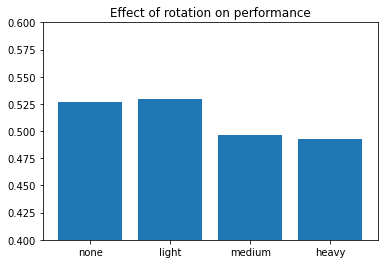

In [25]:
plt.figure()
plt.bar(['none', 'light', 'medium', 'heavy'], 
        [no_blur_acc, light_jitter_acc, medium_jitter_acc, heavy_jitter_acc])
plt.ylim(0.4, 0.6)
plt.title('Effect of rotation on performance')
plt.show()

In [26]:
# run me for rotation experiments!
no_rotate_acc = train_test_pipeline(noise_type = 'none')  # baseline
light_rotate_acc = train_test_pipeline(noise_type = 'rotate', noise_level = 'light')
medium_rotate_acc = train_test_pipeline(noise_type = 'rotate', noise_level = 'medium')
heavy_rotate_acc = train_test_pipeline(noise_type = 'rotate', noise_level = 'heavy')

Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.527400016784668
        test_loss           0.2052007019519806
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5293999910354614
        test_loss           0.2055683135986328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.48339998722076416
        test_loss           0.22092126309871674
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3808000087738037
        test_loss           0.25603270530700684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


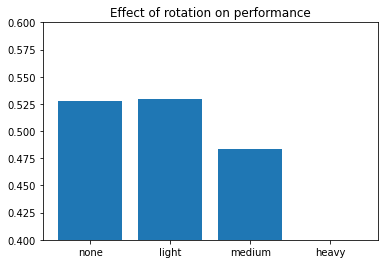

In [27]:
plt.figure()
plt.bar(['none', 'light', 'medium', 'heavy'], 
        [no_rotate_acc, light_rotate_acc, medium_rotate_acc, heavy_rotate_acc])
plt.ylim(0.4, 0.6)
plt.title('Effect of rotation on performance')
plt.show()

### Summary

First, we can observe that for all three noise families, adding heavy noise decreases performance dramatically. The exact amount varies by noise type: for instance, adding heavy rotation reduces performance by 15% whereas heavy jitter only reduces performance by 2-3%.  Second, we observe that the model is relatively resistant to light noise, losing only 0-2% in accuracy. In blurring, almost no loss comes from light noise. Third, sometimes, we might observe that additional noise benefits performance: this is subtle and comes from the effects of data augmentation. Carefully added noise can help prevent overfitting. 

The overall takeaway is that like the NLP example, noise in images can also hurt model performance. However, in both, a light amount of noise is manageable, and can even be interpreted as a benefit. 